The goal of this notebook is to find a $\hat{c} \in \mathbb{R}^d$ (where $d$ is the number of constraints) such that
\begin{equation}
    \lVert h - A^T \hat{c} - K^T w \rVert_2^2 = \min_c \lVert h - A^T c - K^T w \rVert_2^2.
\end{equation}
We want to do this for the starting $w$ so that we are starting the ADMM endpoint optimization as close to a feasible point as possible.

In [1]:
from generate_opt_objects import A_b_generation, starting_point_generation
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.optimize import minimize

In [2]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

# Current starting positions for $c$ and $w$

In [3]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [4]:
# define dimensions
m = y_obs.shape[0]
d = b.shape[0]
p = A.shape[1]

print(m, d, p)

28267 11120 26496


In [5]:
w_sp, c_sp, lambda_sp = starting_point_generation(
    m=m, d=d, p=p,
    random_seed=12345
)

# Getting $K^T w$ for the randomly selected $w$ start

In [17]:
HASH_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/src_admm/data/carbon_flux/results/00'
with open(HASH_DIR + '/h_table_lep.pkl', 'rb') as f:
    KTw_dict = pickle.load(f)

In [25]:
# delete the 0 key
del KTw_dict[0]

In [29]:
# determine the key with the correct K^Tw evaluation
w_distances = dict()
min_dist = 1000.
min_dist_key = 0
for key in KTw_dict.keys():
    dist_key = np.linalg.norm(w_sp - KTw_dict[key]['w'])
    w_distances[key] = dist_key
    if dist_key < min_dist:
        min_dist_key = key
        min_dist = dist_key
        
print(f'Min dist: {min_dist} | Min dist key: {min_dist_key}')

Min dist: 5.513985464335888 | Min dist key: -7416693065889372294


Since we do not have the $K^Tw$ corresponding to the first randomly generated $w$, we see if this is possible with _some_ $w$.

# Trying for feasibility with _some_ $w$

Use the above $w$

In [33]:
KEY = -7416693065889372294

In [42]:
def obj_func(c, h=h, A=A, KTw=KTw_dict[KEY]['KTw']):
    return np.dot(h + A.T @ c - KTw, h + A.T @ c - KTw)

def obj_jac(c, h=h, A=A, KTw=KTw_dict[KEY]['KTw']):
    return 2 * A @ (h + A.T @ c - KTw)

In [46]:
# perform the optimization
c_opt_res = minimize(
    fun=obj_func, x0=c_sp, method='L-BFGS-B',
    jac=obj_jac,
    options={'iprint': 1}
)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11120     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77036D+02    |proj g|=  1.18356D+01

At iterate    1    f=  6.05888D+02    |proj g|=  9.83735D+00

At iterate    2    f=  3.40102D-27    |proj g|=  2.13163D-14

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11120      2      4      1     0     0   2.132D-14   3.401D-27
  F =   3.4010185561787753E-027

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [45]:
c_opt_res['x'].max()

2.4150288105011026

# Feasibility with the actual initial $w$

In [6]:
# read in the randomly generated w
with open('../fixed_optimization_inputs/KTw_for_w_start.npy', 'rb') as f:
    KTw_0 = np.load(f)

In [7]:
def obj_func_0(c, h=h, A=A, KTw=KTw_0):
    return np.dot(h + A.T @ c - KTw, h + A.T @ c - KTw)

def obj_jac_0(c, h=h, A=A, KTw=KTw_0):
    return 2 * A @ (h + A.T @ c - KTw)

In [12]:
# perform the optimization
c_opt_res_0 = minimize(
    fun=obj_func_0, x0=c_sp, method='L-BFGS-B',
    jac=obj_jac_0,
    options={'iprint': 1}
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11120     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19458D+03    |proj g|=  1.51110D+01


 This problem is unconstrained.



At iterate    1    f=  8.73952D+02    |proj g|=  1.29250D+01

At iterate    2    f=  2.07112D-27    |proj g|=  2.30926D-14

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11120      2      4      1     0     0   2.309D-14   2.071D-27
  F =   2.0711166807940697E-027

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [13]:
print(f'Max c val: {c_opt_res_0["x"].max()}')
print(f'Objective: {c_opt_res_0["fun"]}')

Max c val: 7.555489540100109
Objective: 2.0711166807940697e-27


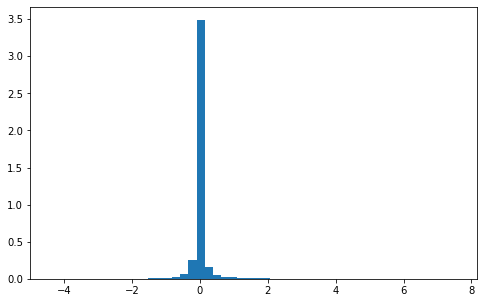

In [16]:
# look at the distribution of the parameter values
plt.figure(figsize=(8, 5))
plt.hist(c_opt_res_0['x'], bins=50, density=True)
plt.show()

# Save the new starting points

In [54]:
SAVE_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization'
SAVE_DIR += '/src_admm/data/carbon_flux/results/01/intermediate_starts'

In [59]:
# w
with open(SAVE_DIR + "/cheyenne_stop_w_vec.npy", 'wb') as f:
    np.save(file=f, arr=w_sp)

# c
with open(SAVE_DIR + "/cheyenne_stop_c_vec.npy", 'wb') as f:
    np.save(file=f, arr=c_opt_res_0["x"])

# lambda
with open(SAVE_DIR + "/cheyenne_stop_lambda_vec.npy", 'wb') as f:
    np.save(file=f, arr=lambda_sp)

# Feasibility with actual $w$ and non-neg constraint on $c$

In [8]:
# perform the optimization
c_opt_res_0_nn = minimize(
    fun=obj_func_0, x0=c_sp, method='L-BFGS-B',
    jac=obj_jac_0, bounds=[(0, None)] * 11120,
    options={'iprint': 1}
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11120     M =           10

At X0     11120 variables are exactly at the bounds

At iterate    0    f=  1.19458D+03    |proj g|=  1.51110D+01

At iterate    1    f=  9.18622D+02    |proj g|=  1.26005D+01

At iterate    2    f=  2.88828D+02    |proj g|=  1.24345D-14

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11120      2      4      2     0  5676   1.243D-14   2.888D+02
  F =   288.82787394424327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [9]:
print(f'Max c val: {c_opt_res_0_nn["x"].max()}')
print(f'Objective: {c_opt_res_0_nn["fun"]}')

Max c val: 7.555489540100091
Objective: 288.82787394424327


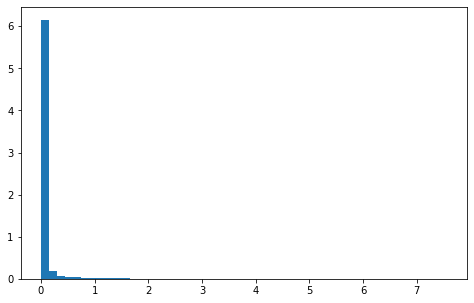

In [10]:
# look at the distribution of the parameter values
plt.figure(figsize=(8, 5))
plt.hist(c_opt_res_0_nn['x'], bins=50, density=True)
plt.show()

In [11]:
print('How much does the optimized c help the feasibility criterion (2-norm)?')
print(f'Feasibility criterion with all zeros: {np.sqrt(obj_func_0(c=c_sp))}')
print(f'Feasibility criterion with opt point: {np.sqrt(obj_func_0(c=c_opt_res_0_nn["x"]))}')

How much does the optimized c help the feasibility criterion (2-norm)?
Feasibility criterion with all zeros: 34.562684606345876
Feasibility criterion with opt point: 16.994936714923163


#### Saving the above

In [12]:
SAVE_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization'
SAVE_DIR += '/src_admm/data/carbon_flux/results/02/intermediate_starts'

In [13]:
# w
with open(SAVE_DIR + "/cheyenne_stop_w_vec.npy", 'wb') as f:
    np.save(file=f, arr=w_sp)

# c
with open(SAVE_DIR + "/cheyenne_stop_c_vec.npy", 'wb') as f:
    np.save(file=f, arr=c_opt_res_0_nn["x"])

# lambda
with open(SAVE_DIR + "/cheyenne_stop_lambda_vec.npy", 'wb') as f:
    np.save(file=f, arr=lambda_sp)

Bad pipe message: %s [b'\xe6\x88\x98?u"\x85{g\r\xfe\xe1\xbe\xba$\xac\x9f? \n\xe2\x04\xe8\x10\xd6D\xab; \x018x\x8at6v\xca\x08Y\xa1\xeb\x15\x1b1,S\xe2&^\xd9\x91\x00***\x13\x01\x13\x02\x13\x03\xc0,\xc0+\xcc\xa9\xc00\xc0/\xcc\xa8\xc0\n\xc0\t\xc0\x14\xc0\x13\x00\x9d\x00\x9c\x005\x00/\xc0\x08\xc0\x12\x00\n\x01\x00\x01\x89\x8a\x8a\x00\x00\x00\x17\x00\x00\xff\x01\x00\x01\x00\x00\n\x00\x0c\x00\n\xaa\xaa\x00\x1d\x00\x17\x00\x18\x00\x19\x00\x0b\x00\x02\x01\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\r\x00\x18\x00\x16\x04\x03\x08\x04\x04\x01\x05\x03\x02\x03\x08\x05\x08\x05\x05\x01\x08\x06\x06\x01\x02\x01\x00\x12\x00\x00\x003\x00+\x00)\xaa\xaa\x00\x01\x00\x00\x1d\x00 \x1f?\xb6\xfa\xce=\x96lT&A\xdd7\n\x8c\xb6\x11\xc4\xf2E\xab\xf2yPeO\xb6B\xfd\xb2\xf9T\x00-\x00\x02\x01\x01\x00+\x00\x0b']
Bad pipe message: %s [b'Z\x03\x04\x03\x03\x03\x02\x03\x01']
Bad pipe message: %s [b'C\xee+\xbd\n\xa9\xca\x98\x16\xec\x90H\x1f\xde\x03\xa7\x0c| g\x1b\xcc\x97\x95\xad\xae\xcb\x